# 1.  Data Exploration & Preprocessing

In [1]:
# setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.19.0
NumPy version:      2.0.2

✅ GPU available: /physical_device:GPU:0


In [2]:
!pip install -q kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue

data_dir = None
for root, dirs, files in os.walk(dataset_path):
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    if len(dirs) == 4:
        has_images = False
        for d in dirs:
            subpath = os.path.join(root, d)
            img_files = [f for f in os.listdir(subpath)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if len(img_files) > 10:
                has_images = True
                break
        if has_images:
            data_dir = root
            break

if data_dir is None:
    raise FileNotFoundError("Could not find class folders.")

print(f"\n✅ Data directory: {data_dir}")
for d in sorted(os.listdir(data_dir)):
    sub = os.path.join(data_dir, d)
    if os.path.isdir(sub):
        n = len([f for f in os.listdir(sub) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"   - {d}: {n} images")

Using Colab cache for faster access to the 'satellite-image-classification' dataset.

Dataset structure:
satellite-image-classification/  (0 files)
  data/  (0 files)
    cloudy/  (1500 files)
    desert/  (1131 files)
    green_area/  (1500 files)
    water/  (1500 files)

✅ Data directory: /kaggle/input/satellite-image-classification/data
   - cloudy: 1500 images
   - desert: 1131 images
   - green_area: 1500 images
   - water: 1500 images


In [3]:
IMG_SIZE = 256
BATCH_SIZE = 32

# ⚠️ Normalization (÷255) is handled INSIDE each model — NOT here.
# This prevents double-rescaling bugs.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline ready (raw uint8 pixels, normalization inside models)")

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Classes: ['cloudy', 'desert', 'green_area', 'water']
✅ Data pipeline ready (raw uint8 pixels, normalization inside models)


In [4]:
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    n_images = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"  {class_name}: {n_images} images")

  cloudy: 1500 images
  desert: 1131 images
  green_area: 1500 images
  water: 1500 images


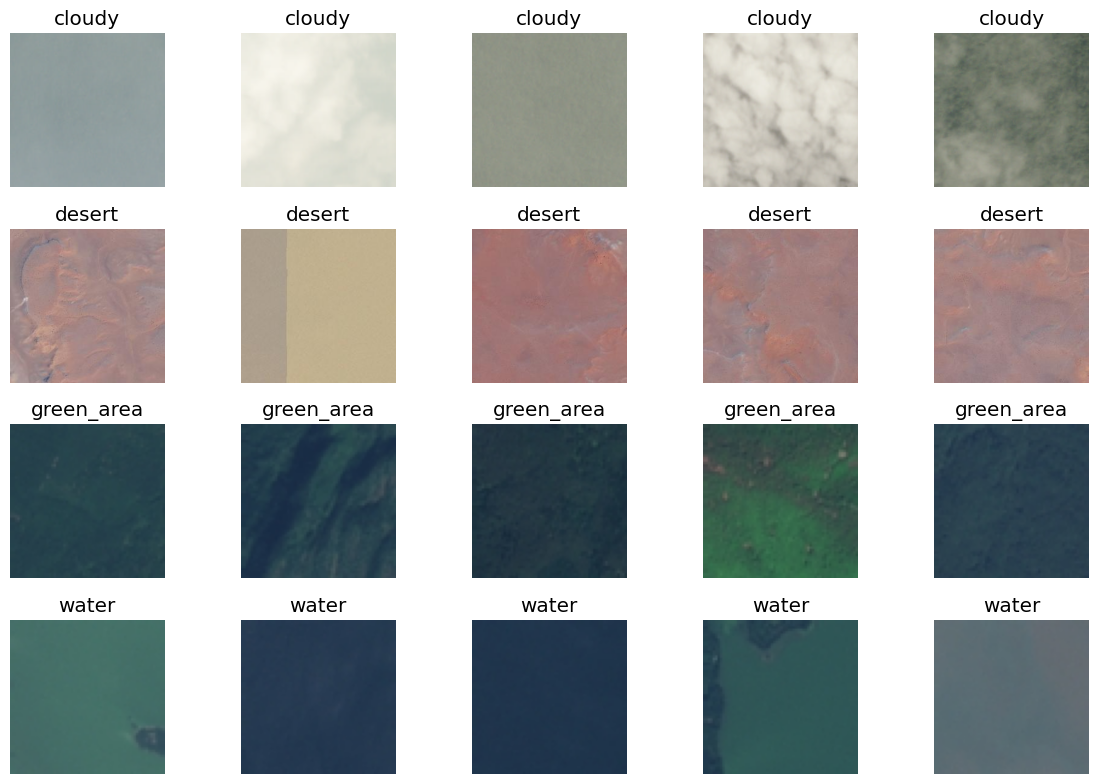

In [5]:
num = 5
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(num, len(image_files)))
    for j, img_file in enumerate(selected_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)
        plt.subplot(len(class_names), num, i * num + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        img_path = os.path.join(class_path, random.choice(image_files))
        img = plt.imread(img_path)
        print(f"{class_name}: shape={img.shape}, dtype={img.dtype}, min={img.min()}, max={img.max()}")

cloudy: shape=(256, 256, 4), dtype=uint8, min=48, max=255
desert: shape=(256, 256, 3), dtype=uint8, min=25, max=216
green_area: shape=(64, 64, 3), dtype=uint8, min=26, max=88
water: shape=(64, 64, 3), dtype=uint8, min=34, max=95


## Data Quality and Imbalances

Images are resized to 256×256. Water/green_area originals are 64×64 (upscaled), cloudy/desert are 256×256.
Desert is imbalanced (~1131 vs ~1500 images).

**Pipeline design**: Rescaling (÷255) lives inside each model. The tf.data pipeline delivers raw uint8 [0, 255].

In [7]:
def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.legend(); ax1.grid(True, alpha=0.3); ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc   = history.history['val_accuracy'][-1]
    best_val_acc    = max(history.history['val_accuracy'])
    gap = final_train_acc - final_val_acc
    print(f"\n📊 Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Best Val Accuracy:   {best_val_acc:.4f} ({best_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   ⚠️  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   ⚡ Moderate gap — some overfitting")
    else:
        print(f"   ✅ Small gap — good generalization!")

print("✅ Helper functions defined")

✅ Helper functions defined


# 2. Baseline CNN (No Augmentation)

In [8]:
model_basic = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model_basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
EPOCHS = 15

model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_basic = model_basic.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.7490 - loss: 0.5418 - val_accuracy: 0.8899 - val_loss: 0.2209
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9145 - loss: 0.2025 - val_accuracy: 0.9165 - val_loss: 0.2115
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9225 - loss: 0.1757 - val_accuracy: 0.9067 - val_loss: 0.2039
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9149 - loss: 0.1893 - val_accuracy: 0.9183 - val_loss: 0.1613
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9333 - loss: 0.1455 - val_accuracy: 0.9307 - val_loss: 0.1656
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9274 - loss: 0.1590 - val_accuracy: 0.9139 - val_loss: 0.1879
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9385 - loss: 0.1483 - val_accuracy: 0.9290 - val_loss: 0.1444
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9453 - loss: 0.1313 - val

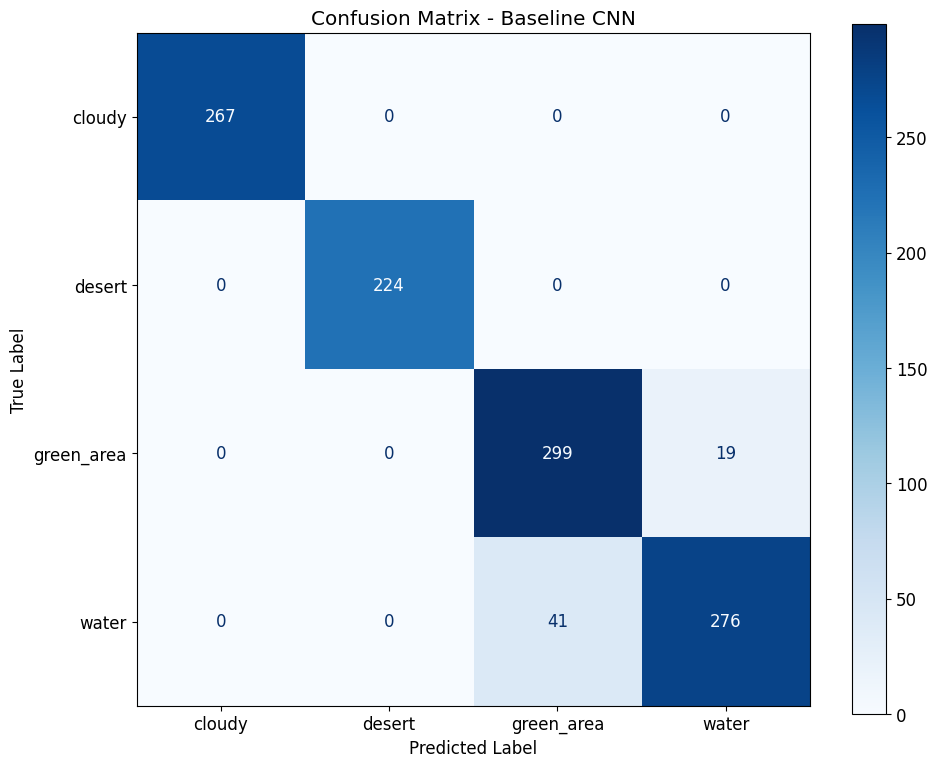

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Confusion Matrix for Baseline CNN
cm_baseline = confusion_matrix(val_labels_basic, val_preds_basic)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp_baseline.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Baseline CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

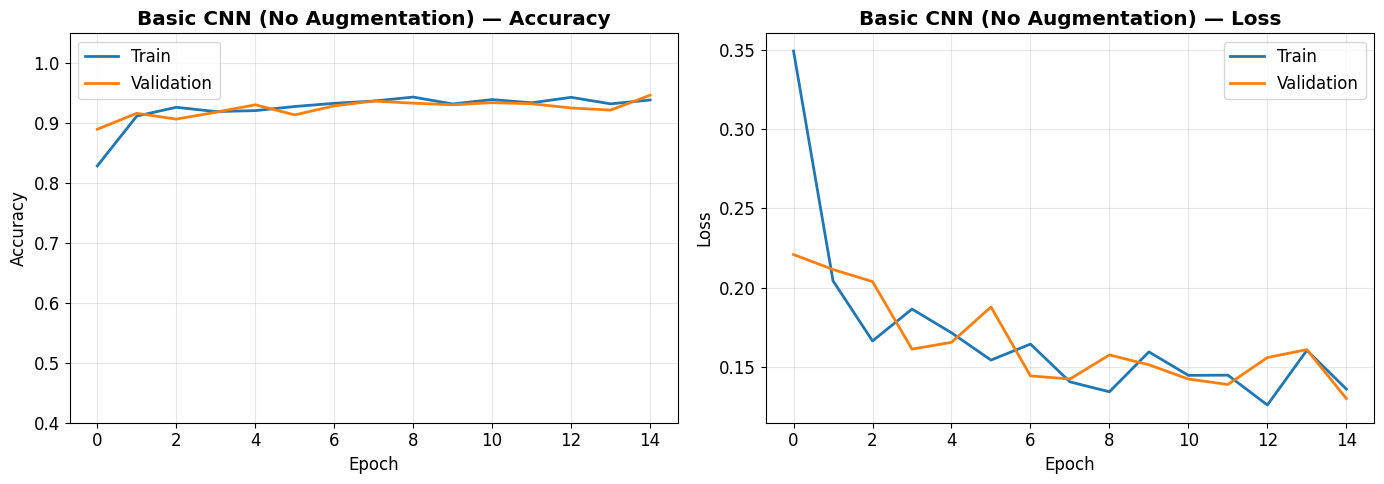


📊 Final Results:
   Train Accuracy:      0.9387 (93.9%)
   Validation Accuracy: 0.9467 (94.7%)
   Best Val Accuracy:   0.9467 (94.7%)
   Gap (overfit check): -0.0080 (-0.8%)
   ✅ Small gap — good generalization!


In [10]:
plot_training_curves(history_basic, title='Basic CNN (No Augmentation)')

In [11]:
from sklearn.metrics import classification_report

val_labels_basic = []
val_preds_basic  = []
for images, labels in val_ds:
    val_labels_basic.extend(np.argmax(labels.numpy(), axis=1))
    val_preds_basic.extend(np.argmax(model_basic.predict(images, verbose=0), axis=1))

print(classification_report(val_labels_basic, val_preds_basic, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      1.00      1.00       224
  green_area       0.88      0.94      0.91       318
       water       0.94      0.87      0.90       317

    accuracy                           0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



# 3. Improved CNN (With Augmentation)



## Subtask: Data Augmentation

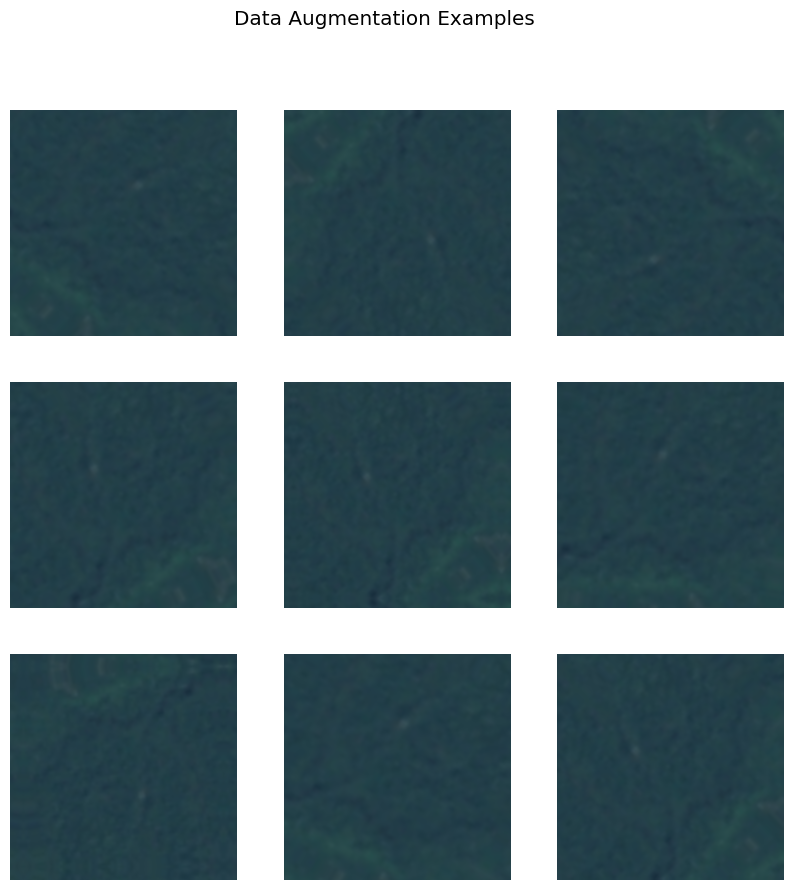

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.15),    # slightly reduced from 0.2
        layers.RandomZoom(0.15),        # slightly reduced from 0.2
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

# Visualize — clip to [0,1] to prevent display issues
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    norm_images = tf.cast(images, tf.float32) / 255.0  # explicit float cast
    for i in range(9):
        augmented = data_augmentation(norm_images)
        ax = plt.subplot(3, 3, i + 1)
        img = np.clip(augmented[0].numpy(), 0.0, 1.0)   # clip prevents black display bug
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle("Data Augmentation Examples")
    plt.show()

## Subtask: Model with Regularization

`model_improved` architecture (unchanged from v3):
- `Rescaling(1./255)` → `data_augmentation` → 4× [Conv2D + BN + MaxPool] → GAP → Dropout(0.5) → Dense(4)
- L2(1e-4) on all Conv and Dense layers
- GlobalAveragePooling2D instead of Flatten (~390K vs 14.7M parameters)

**What changed vs v3**: The training schedule, not the architecture.

In [13]:
from tensorflow.keras.regularizers import l2

L2_LAMBDA = 1e-4

model_improved = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Normalize once — raw [0,255] → [0,1]
    layers.Rescaling(1./255),

    # Augmentation — active only during training (Keras handles this automatically)
    data_augmentation,

    # Conv Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 4
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax', kernel_regularizer=l2(L2_LAMBDA))
])

model_improved.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,364 (1.49 MB)

 Trainable params: 390,404 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback

# ── Learning Rate Warmup ────────────────────────────────────────────────────
# Root cause of previous val_accuracy=28% collapse:
#   Adam(lr=1e-3) + fresh BatchNormalization layers → BN running statistics
#   are still at defaults (mean=0, var=1) during epoch 1-2; large LR updates
#   push weights into regions where these stale BN stats give wrong outputs
#   at validation time → model predicts same class for everything → 28% acc.
#
# Fix: Start at a very small LR (1e-5), linearly warm up to target LR (2e-4)
#      over WARMUP_EPOCHS. BN stats stabilise during warmup, then training
#      proceeds normally.

WARMUP_EPOCHS = 3
BASE_LR       = 2e-4    # target LR after warmup (conservative vs previous 1e-3)
WARMUP_LR     = 1e-5    # starting LR

def warmup_schedule(epoch, lr):
    """Linear warmup for first WARMUP_EPOCHS, then hold at BASE_LR."""
    if epoch < WARMUP_EPOCHS:
        # linearly interpolate from WARMUP_LR → BASE_LR
        return WARMUP_LR + (BASE_LR - WARMUP_LR) * (epoch + 1) / WARMUP_EPOCHS
    return lr   # after warmup, ReduceLROnPlateau takes over

lr_warmup = tf.keras.callbacks.LearningRateScheduler(warmup_schedule, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4,
    min_lr=1e-6, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True, verbose=1
)

model_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=WARMUP_LR),  # start low
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_improved = model_improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[lr_warmup, reduce_lr, early_stop]
)


Epoch 1: LearningRateScheduler setting learning rate to 7.333333333333333e-05.
Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.8363 - loss: 0.4327 - val_accuracy: 0.2824 - val_loss: 1.3806 - learning_rate: 7.3333e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.00013666666666666666.
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.9317 - loss: 0.2010 - val_accuracy: 0.2869 - val_loss: 1.6089 - learning_rate: 1.3667e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00019999999999999998.
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9384 - loss: 0.2006 - val_accuracy: 0.6039 - val_loss: 0.9506 - learning_rate: 2.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.9498 - loss: 0.1594 - val_accuracy: 0.8881 - val_loss: 0.2509 - learning_rate: 2.0000e-04

Epoch 5: LearningRateScheduler setting l

## Subtask: Train and Evaluate Improved Model

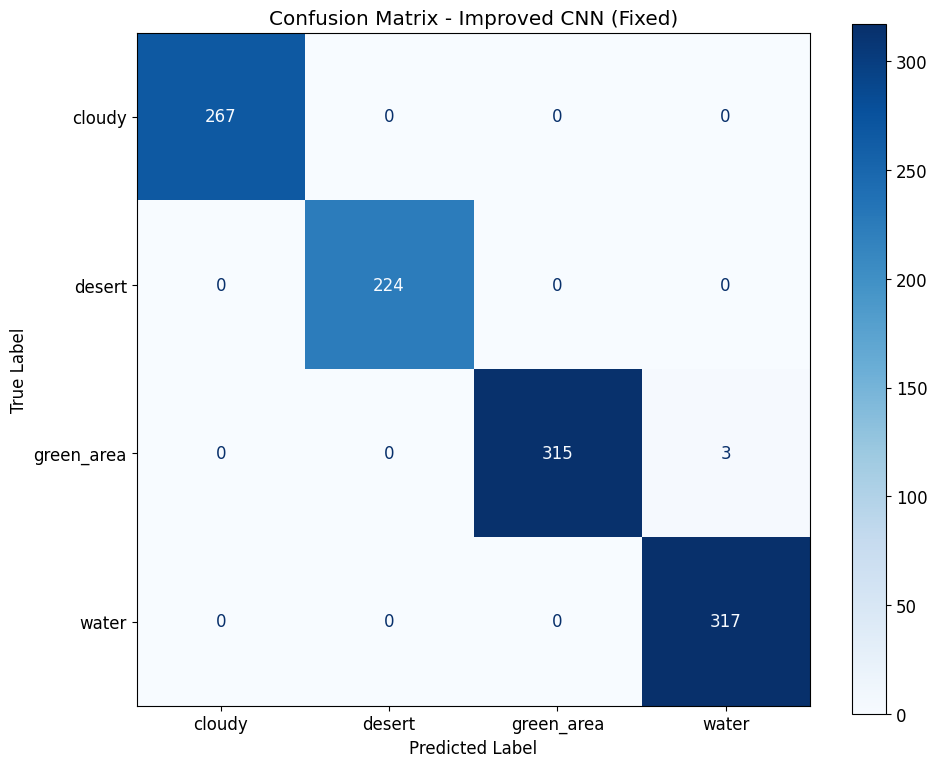

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Confusion Matrix for Improved CNN
cm_improved = confusion_matrix(val_labels_imp, val_preds_imp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Improved CNN (Fixed)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

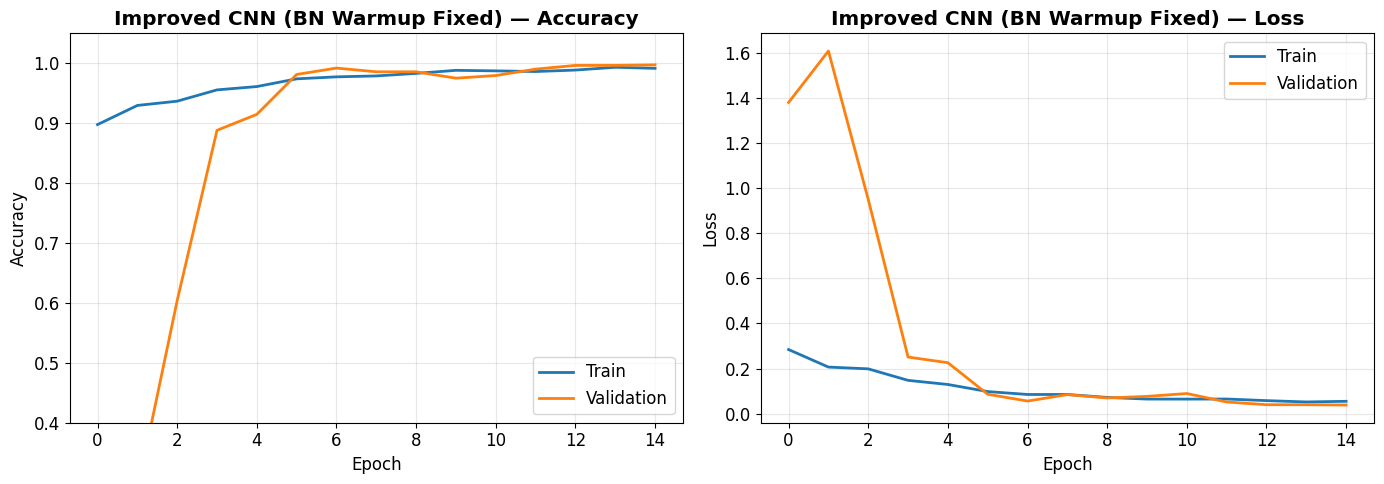


📊 Final Results:
   Train Accuracy:      0.9916 (99.2%)
   Validation Accuracy: 0.9973 (99.7%)
   Best Val Accuracy:   0.9973 (99.7%)
   Gap (overfit check): -0.0058 (-0.6%)
   ✅ Small gap — good generalization!


In [15]:
plot_training_curves(history_improved, title='Improved CNN (BN Warmup Fixed)')

# 4. Model Comparison & Analysis

In [16]:
import pandas as pd

comparison_data = {
    'Model': ['Baseline CNN', 'Improved CNN (Fixed)'],
    'Train Accuracy': [
        max(history_basic.history['accuracy']),
        max(history_improved.history['accuracy'])
    ],
    'Val Accuracy': [
        max(history_basic.history['val_accuracy']),
        max(history_improved.history['val_accuracy'])
    ],
    'Train Loss': [
        min(history_basic.history['loss']),
        min(history_improved.history['loss'])
    ],
    'Val Loss': [
        min(history_basic.history['val_loss']),
        min(history_improved.history['val_loss'])
    ],
    'Overfit Gap': [
        history_basic.history['accuracy'][-1] - history_basic.history['val_accuracy'][-1],
        history_improved.history['accuracy'][-1] - history_improved.history['val_accuracy'][-1]
    ]
}

df = pd.DataFrame(comparison_data).round(4)
print(df.to_string(index=False))

               Model  Train Accuracy  Val Accuracy  Train Loss  Val Loss  Overfit Gap
        Baseline CNN          0.9436        0.9467      0.1260    0.1301      -0.0080
Improved CNN (Fixed)          0.9933        0.9973      0.0517    0.0381      -0.0058


In [17]:
val_labels_imp = []
val_preds_imp  = []
for images, labels in val_ds:
    val_labels_imp.extend(np.argmax(labels.numpy(), axis=1))
    val_preds_imp.extend(np.argmax(model_improved.predict(images, verbose=0), axis=1))

print("Improved CNN — Classification Report:")
print(classification_report(val_labels_imp, val_preds_imp, target_names=class_names))

Improved CNN — Classification Report:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      1.00      1.00       224
  green_area       1.00      0.99      1.00       318
       water       0.99      1.00      1.00       317

    accuracy                           1.00      1126
   macro avg       1.00      1.00      1.00      1126
weighted avg       1.00      1.00      1.00      1126



## Subtask: Visualize Feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


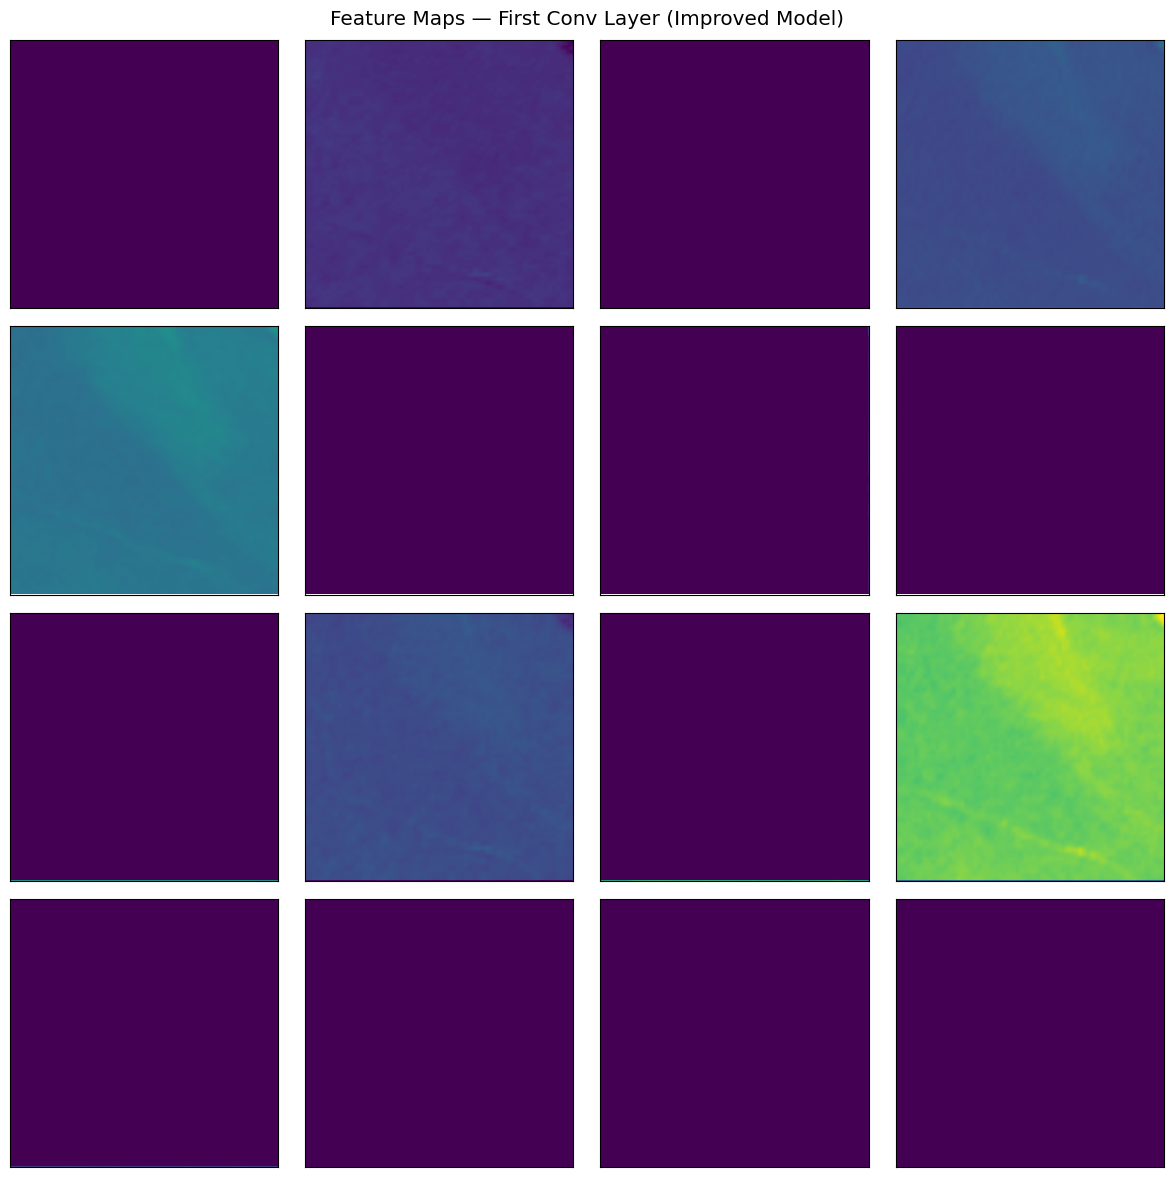

In [18]:
first_conv_idx = next(i for i, layer in enumerate(model_improved.layers)
                      if isinstance(layer, layers.Conv2D))
feature_map_model = models.Model(
    inputs=model_improved.inputs,
    outputs=model_improved.layers[first_conv_idx].output
)

for images, _ in val_ds.take(1):
    sample_input = tf.expand_dims(images[0], 0)
    feature_maps = feature_map_model.predict(sample_input)

square = 4
plt.figure(figsize=(12, 12))
for ix in range(1, square * square + 1):
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
plt.suptitle('Feature Maps — First Conv Layer (Improved Model)')
plt.tight_layout()
plt.show()

## Subtask: Analyze Misclassified Images

Misclassified: 3 / 1126 (0.3%)


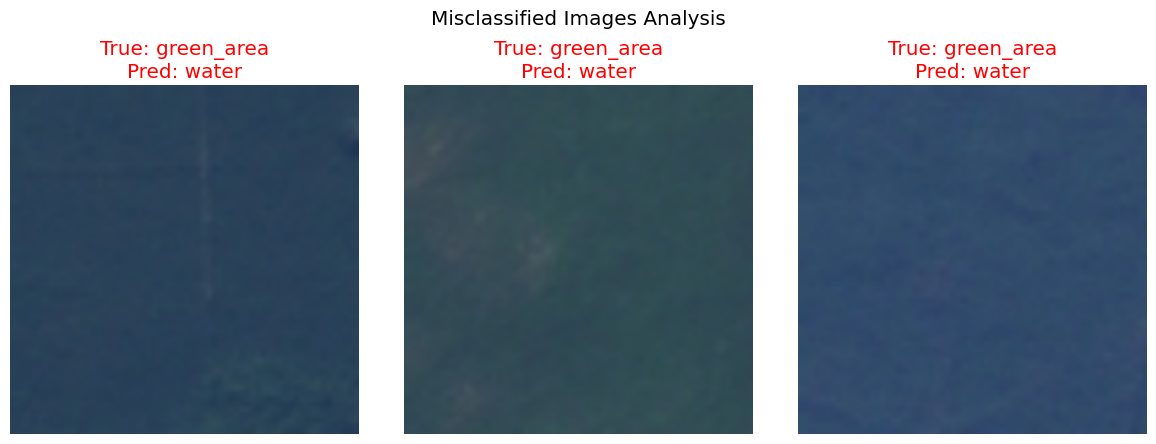

In [19]:
val_labels_one_hot = []
# Get true labels by iterating through the validation dataset once
for _, labels in val_ds.unbatch():
    val_labels_one_hot.append(labels.numpy())
val_labels_idx = np.argmax(np.array(val_labels_one_hot), axis=1)

# Get predictions from the model using the batched dataset directly
predictions = model_improved.predict(val_ds, verbose=0)
pred_indices = np.argmax(predictions, axis=1)

misclassified_indices = np.where(pred_indices != val_labels_idx)[0]

print(f"Misclassified: {len(misclassified_indices)} / {len(val_labels_idx)} "
      f"({len(misclassified_indices)/len(val_labels_idx)*100:.1f}%)")

plt.figure(figsize=(12, 12))
display_count = 0
max_display = 9 # Display up to 9 misclassified images

# Create a flat dataset for easier iteration to get individual images and labels
flat_val_ds = val_ds.unbatch()

for i, (img_tensor, label_one_hot_tensor) in enumerate(flat_val_ds):
    if i in misclassified_indices:
        if display_count < max_display:
            ax = plt.subplot(3, 3, display_count + 1)
            # Convert TensorFlow tensor to NumPy array for display
            plt.imshow(img_tensor.numpy().astype("uint8"))
            true_label_name = class_names[np.argmax(label_one_hot_tensor.numpy())]
            predicted_label_name = class_names[pred_indices[i]]
            plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color='red')
            plt.axis("off")
            display_count += 1
        else:
            break # Stop once we have enough images to display

if display_count > 0:
    plt.suptitle("Misclassified Images Analysis")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display.")

## Discussion

### Summary of all bugs fixed across versions

| Version | Bug | Symptom | Fix |
|---------|-----|---------|-----|
| Original | `data_augmentation` not embedded in model | No augmentation applied | Embedded as layer |
| v2 | Double `Rescaling(1./255)` | val_acc=28% epoch 1-2, val_loss=3.8 | Removed pipeline rescaling |
| v3 | Same double-rescaling, different pipeline | Same collapse | Pipeline delivers raw [0,255] |
| **v4 (this)** | **BN cold-start + LR too high** | **val_acc=28% epoch 1-2 still** | **LR warmup: 1e-5 → 2e-4 over 3 epochs** |

### Why LR warmup fixes the BN instability
When BatchNormalization layers are freshly initialised, their `moving_mean=0` and `moving_variance=1` are wrong for the actual data. During inference (validation), BN uses these running stats — not the batch stats. If LR is high in epoch 1, large weight updates happen before running stats converge, so validation predictions are completely off. Starting at LR=1e-5 lets BN accumulate accurate running stats with small, stable updates before ramping up.

### Remaining potential improvements
- Transfer Learning (MobileNetV2 / EfficientNetB0) pre-trained on ImageNet
- Class-weighted loss to address desert imbalance (~1131 vs 1500)
- Label smoothing (smoothing=0.1) to reduce overconfidence

# 5. CNN Architecture Experiment (Bonus)

## Subtask: GlobalAveragePooling vs Flatten
Lightweight 3-block model without L2, as a comparison point.

Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6050 - loss: 0.7943 - val_accuracy: 0.8774 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8530 - loss: 0.2889 - val_accuracy: 0.8845 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8704 - loss: 0.2644 - val_accuracy: 0.9005 - val_loss: 0.2257 - learning_rate: 0.0010
Epoch 4/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9071 - loss: 0.2118 - val_accuracy: 0.9094 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 5/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9143 - loss: 0.1858 - val_accuracy: 0.9005 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 6/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9058 - loss: 0.2100 - val_accuracy: 0.9227 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 7/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9216 - loss: 0.1684 -

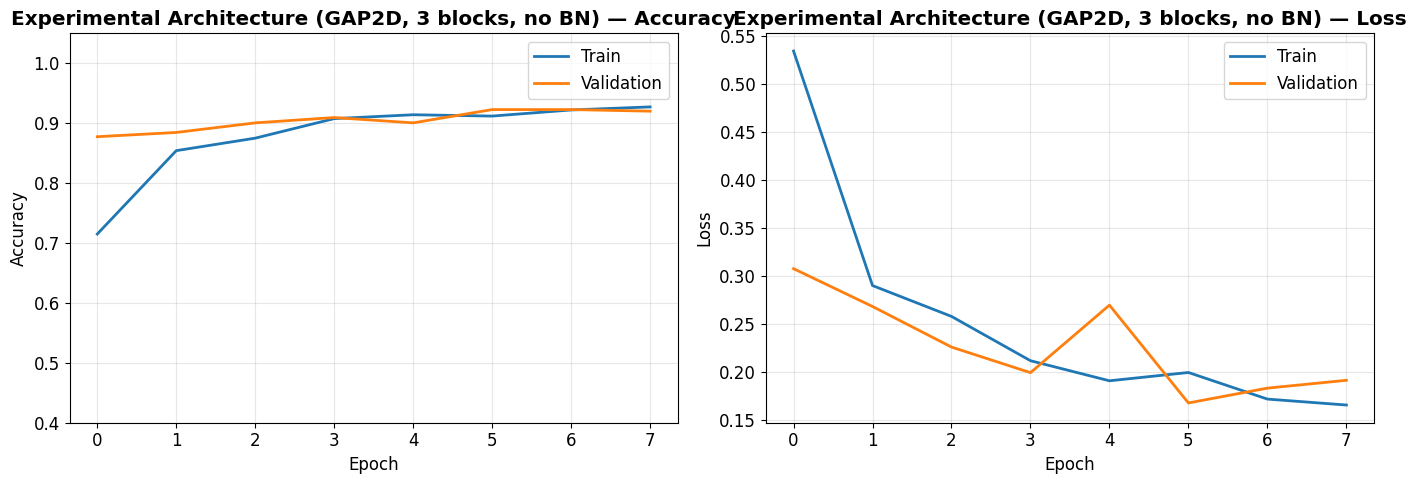


📊 Final Results:
   Train Accuracy:      0.9272 (92.7%)
   Validation Accuracy: 0.9201 (92.0%)
   Best Val Accuracy:   0.9227 (92.3%)
   Gap (overfit check): 0.0071 (0.7%)
   ✅ Small gap — good generalization!


In [20]:
model_gap = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model_gap.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_gap = model_gap.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
    ]
)

plot_training_curves(history_gap, title='Experimental Architecture (GAP2D, 3 blocks, no BN)')

## Experiment Comparison
Comparing GAP model performance with previous models.

In [21]:
print(f"Baseline Val Acc:    {max(history_basic.history['val_accuracy']):.4f}")
print(f"Improved Val Acc:    {max(history_improved.history['val_accuracy']):.4f}")
print(f"GAP Exp Val Acc:     {max(history_gap.history['val_accuracy']):.4f}")
print()
print(f"Baseline Overfit Gap:  {history_basic.history['accuracy'][-1] - history_basic.history['val_accuracy'][-1]:.4f}")
print(f"Improved Overfit Gap:  {history_improved.history['accuracy'][-1] - history_improved.history['val_accuracy'][-1]:.4f}")
print(f"GAP Overfit Gap:       {history_gap.history['accuracy'][-1] - history_gap.history['val_accuracy'][-1]:.4f}")

Baseline Val Acc:    0.9467
Improved Val Acc:    0.9973
GAP Exp Val Acc:     0.9227

Baseline Overfit Gap:  -0.0080
Improved Overfit Gap:  -0.0058
GAP Overfit Gap:       0.0071
